In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from flux.form_factors import get_form_factor_matrix
from flux.shape import CgalTrimeshShapeModel, get_surface_normals, get_centroids
from flux.quadtree import get_quadrant_order

from tqdm import tqdm
import arrow

from sklearn.decomposition import NMF

import os

# Individual Block Compression Comparison

Consider an individual block of the form factor matrix. Compare the relative error and execution time of an array of matrix compression techniques.

### Define the matrix decomposition techniques.

In [123]:
def simple_range_finder(X, k, p=5, q=1, rand_dist='uniform'):
    m,n = X.shape
    
    l = k + p
    
    if rand_dist == 'uniform':
        Omega = np.random.uniform(low=0.0, high=1.0, size=(n,l))
    elif rand_dist == 'normal':
        Omega = np.random.normal(loc=0.0, scale=1.0, size=(n,l))
        
    Y = X @ Omega
    
    for j in range(q):
        Q = np.linalg.qr(Y, mode='reduced')[0]
        Q = np.linalg.qr(X.T @ Q, mode='reduced')[0]
        Y = X @ Q
        
    Q = np.linalg.qr(Y, mode='reduced')[0]
    
    return Q

In [124]:
def interpolative_decomp_index_set(A, k):

    m, n = A.shape

    Q, R, P = scipy.linalg.qr(A, mode='economic', overwrite_a=False, pivoting=True,
                        check_finite=False)

    C = A[:, P[:k]]

    T =  scipy.linalg.pinv(R[:k, :k]).dot(R[:k, k:n])
    V = np.bmat([[np.eye(k), T]])
    V = V[:, np.argsort(P)]

    return P[:k], V


def random_interpolative_decomp(A, k, p=5, q=5):

    Q = simple_range_finder(A, k, p=p, q=q)
    B = Q.T @ A

    J, V = interpolative_decomp_index_set(B, k)
    J = J[:k]

    return scipy.sparse.csr_matrix(A[:, J]), scipy.sparse.csr_matrix(V)

In [125]:
def interpolative_decomp(A, k):
    
    m, n = A.shape

    Q, R, P = scipy.linalg.qr(A, mode='economic', overwrite_a=False, pivoting=True,
                        check_finite=False)

    C = A[:, P[:k]]

    T =  linalg.pinv(R[:k, :k]).dot(R[:k, k:n])
    V = np.bmat([[np.eye(k), T]])
    V = V[:, np.argsort(P)]

    return C, V

In [9]:
def bilateral_random_projection(X, k):
    
    m, n = X.shape
    
    A1 = np.random.normal(loc=0.0, scale=1.0, size=(n,k))
    Y1 = X @ A1
    
    A2 = np.copy(Y1)
    Y2 = X.T @ A2
    
    A1 = np.copy(Y2)
    Y1 = X @ A1
    
    Q1, R1 = np.linalg.qr(Y1, mode='reduced')
    Q2, R2 = np.linalg.qr(Y2, mode='reduced')
    
    return scipy.sparse.csr_matrix(Y1), scipy.sparse.csr_matrix(np.linalg.inv(A2.T @ Y1)), scipy.sparse.csr_matrix(Y2)

In [4]:
def cross_approximation_partial(M, k):
    
    for i in range(M.shape[0]):
        if not (M[i,:] == np.zeros_like(M[i,:])).all():
            i_star = i
            break
    
    row_pivot_idx = []
    A = np.empty((M.shape[0], 0))
    B = np.empty((0, M.shape[1]))
    F_hat = A @ B
    
    nu = 1
    while nu < k:
        j_star = np.argmax(abs(M[i_star,:] - F_hat[i_star,:]))
        delta = M[i_star,j_star] - F_hat[i_star,j_star]
        
        if delta == 0:
            return A, B
        
        a_nu = (M[:, j_star] - F_hat[:,j_star]).reshape(-1,1)
        b_nu = ((M[i_star, :] - F_hat[i_star,:]) / delta).reshape(-1,1)
        
        A = np.concatenate([A, a_nu], axis=1)
        B = np.concatenate([B, b_nu.T], axis=0)
        F_hat = A @ B
        
        row_pivot_idx.append(i_star)
        
        # get the next row pivot index
        i_star = None
        i_sorted = np.argsort(abs(M[:, j_star] - F_hat[:, j_star]))[::-1]
        for i in i_sorted:
            if i not in row_pivot_idx and not (M[i,:] - F_hat[i, :] == np.zeros_like(M[i,:])).all():
                i_star = i
                break
        
        if i_star is None:
            raise RuntimeError("Could not find unused row pivot index")
            
        nu += 1
    
    return A, B

In [5]:
def cross_approximation_full(M, k):
    A = np.empty((M.shape[0], 0))
    B = np.empty((0, M.shape[1]))
    F_hat = A @ B
    
    nu = 1
    while nu < k:
        i_star, j_star = np.unravel_index(np.argmax(abs(M - F_hat)), M.shape)
        delta = M[i_star,j_star] - F_hat[i_star,j_star]
        
        if delta == 0:
            return A, B
        
        a_nu = (M[:, j_star] - F_hat[:,j_star]).reshape(-1,1)
        b_nu = ((M[i_star, :] - F_hat[i_star,:]) / delta).reshape(-1,1)
        
        A = np.concatenate([A, a_nu], axis=1)
        B = np.concatenate([B, b_nu.T], axis=0)
        F_hat = A @ B
                   
        nu += 1
    
    return A, B

In [39]:
def randomized_HALS(X, Q, k, tol=1e-4, max_iters=1e4):
    m,n = X.shape
    
    l = Q.shape[1]
    
    W = np.random.uniform(low=0.0, high=1.0, size=(m,k))
    _W = np.random.uniform(low=0.0, high=1.0, size=(l,k))
    H = np.random.uniform(low=0.0, high=1.0, size=(k,n))
    
    B = Q.T @ X        # l x n
    
    criterion = True
    num_iters = 0
    H_norm = np.linalg.norm(H, ord='fro')
    while criterion:
        
        R = B.T @ _W       # n x k
        S = _W.T @ _W      # k x k
        for j in range(k):
            if S[j,j] != 0:
                H[j,:] = H[j,:] + ((R[:,j] - (H.T @ S[:,j])) / S[j,j])
                H[j,:] = np.maximum(H[j,:], 0.)
            
        T = B @ H.T        # l x k
        V = H @ H.T        # k x k
        for j in range(k):
            if V[j,j] != 0:
                _W[:,j] = _W[:,j] + ((T[:,j] - (_W @ V[:,j])) / V[j,j])
                W[:,j] = np.maximum(0, Q @ _W[:,j])
                _W[:,j] = Q.T @ W[:,j]
            
        num_iters += 1
        if num_iters >= max_iters:
            print('Exceeded max_iters')
            criterion = False
           
        new_H_norm = np.linalg.norm(H, ord='fro')
        if (abs(H_norm - new_H_norm) / H_norm)  < tol:
            criterion = False
            
        if np.isnan(W).any() or np.isnan(H).any():
            criterion = False
        
        H_norm = new_H_norm
            
    return W, H

### Load the shape mesh and extract a form factor block.

Make sure the directory to the mesh is correct on your machine!

In [1]:
mesh_dir = 'python-flux/examples/gerlache/'
mesh_name = 'gerlache'

In [10]:
max_inner_area = 0.8
max_outer_area = 3

max_inner_area_str = str(max_inner_area)
max_outer_area_str = str(max_outer_area)

In [11]:
V = np.load(f'{mesh_dir}/{mesh_name}_verts_{max_inner_area_str}_{max_outer_area_str}.npy')
F = np.load(f'{mesh_dir}/{mesh_name}_faces_{max_inner_area_str}_{max_outer_area_str}.npy')

# convert verts from km to m
V *= 1e3

N = get_surface_normals(V, F)
N[N[:, 2] > 0] *= -1

P = get_centroids(V, F)
Is = get_quadrant_order(P[:,:2])

faces_padded = np.concatenate([3*np.ones(F.shape[0],dtype=int).reshape(-1,1), F], axis=1)

shape_model = CgalTrimeshShapeModel(V, F, N)

num_faces = F.shape[0]
print('created mesh with %d triangles' % num_faces)

created mesh with 2078 triangles


In [13]:
I = Is[0]
J = Is[2]
FF = get_form_factor_matrix(shape_model, I, J)
FF_arr = FF.A
FF.shape, FF.nnz

((519, 527), 35056)

### Compress this block matrix using each method.

Change rootpath to decide where you want to save results!

In [ ]:
rootpath = "individual_block_comparison"
if not os.path.exists(rootpath):
    os.mkdir(rootpath)

In [50]:
k_range = np.arange(10, min(FF_arr.shape[0], FF_arr.shape[1]), 1)

In [146]:
if os.path.exists(rootpath+"/sklearn_nmf_compute_times.npy") and os.path.exists(rootpath+"/sklearn_nmf_errs.npy"):
    sklearn_nmf_compute_times = np.load(rootpath+"/sklearn_nmf_compute_times.npy")
    sklearn_nmf_errs = np.load(rootpath+"/sklearn_nmf_errs.npy")
else:
    sklearn_nmf_compute_times = []
    sklearn_nmf_errs = []

    tol=1e-4
    max_iters=1e5

    for k in tqdm(k_range[::10]):
        start_time = arrow.now()

        nmf = NMF(k, init='random', solver='cd', tol=tol, max_iter=int(max_iters), beta_loss=2)
        W = nmf.fit_transform(FF)
        H = nmf.components_

        err = np.linalg.norm(FF - (W @ H), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        sklearn_nmf_errs.append(err)
        sklearn_nmf_compute_times.append((arrow.now()-start_time).total_seconds())
    
    np.save(rootpath+"/sklearn_nmf_compute_times.npy", sklearn_nmf_compute_times)
    np.save(rootpath+"/sklearn_nmf_errs.npy", sklearn_nmf_errs)

 41%|███████████████████████████████████████████████▎                                                                   | 21/51 [54:22<1:17:41, 155.38s/it]


KeyboardInterrupt: 

In [121]:
if os.path.exists(rootpath+"/rHALS_compute_times.npy") and os.path.exists(rootpath+"/rHALS_errs.npy"):
    rHALS_compute_times = np.load(rootpath+"/rHALS_compute_times.npy")
    rHALS_errs = np.load(rootpath+"/rHALS_errs.npy")
else:
    rHALS_compute_times = []
    rHALS_errs = []

    tol=1e-1
    max_iters=1e5

    for k in tqdm(k_range):
        start_time = arrow.now()

        Q = simple_range_finder(FF, k, p=5, q=1)
        W, H = randomized_HALS(FF, Q, k, tol=tol, max_iters=max_iters)
        
        if np.isnan(W).any() or np.isnan(H).any():
            err = 1.
        else:
            err = np.linalg.norm(FF - (W @ H), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        rHALS_errs.append(err)
        rHALS_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/rHALS_compute_times.npy", rHALS_compute_times)
    np.save(rootpath+"/rHALS_errs.npy", rHALS_errs)

  5%|█████▋                                                                                                               | 25/509 [00:02<01:22,  5.84it/s]C:\Users\mwrep\AppData\Local\Temp\ipykernel_5528\3741267743.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  if (abs(H_norm - new_H_norm) / H_norm)  < tol:
 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 324/509 [09:10<11:26,  3.71s/it]C:\Users\mwrep\AppData\Local\Temp\ipykernel_5528\3741267743.py:28: RuntimeWarning: invalid value encountered in matmul
  _W[:,j] = _W[:,j] + ((T[:,j] - (_W @ V[:,j])) / V[j,j])
C:\Users\mwrep\AppData\Local\Temp\ipykernel_5528\3741267743.py:28: RuntimeWarning: invalid value encountered in divide
  _W[:,j] = _W[:,j] + ((T[:,j] - (_W @ V[:,j])) / V[j,j])
 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 339/509 [12:35<29:44, 10.49s/it]C:\Us

In [52]:
if os.path.exists(rootpath+"/rSVD_compute_times.npy") and os.path.exists(rootpath+"/rSVD_errs.npy"):
    rSVD_compute_times = np.load(rootpath+"/rSVD_compute_times.npy")
    rSVD_errs = np.load(rootpath+"/rSVD_errs.npy")
else:
    rSVD_compute_times = []
    rSVD_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        Q = simple_range_finder(FF, k, p=5, q=1)
        B = Q.T @ FF
        _U, S, Vt = np.linalg.svd(B, full_matrices=False)
        U = Q @ _U

        err = np.linalg.norm(FF - (U @ np.diag(S) @ Vt), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        rSVD_errs.append(err)
        rSVD_compute_times.append((arrow.now()-start_time).total_seconds())

    np.save(rootpath+"/rSVD_compute_times.npy", rSVD_compute_times)
    np.save(rootpath+"/rSVD_errs.npy", rSVD_errs)

In [53]:
if os.path.exists(rootpath+"/SVD_compute_times.npy") and os.path.exists(rootpath+"/SVD_errs.npy"):
    SVD_compute_times = np.load(rootpath+"/SVD_compute_times.npy")
    SVD_errs = np.load(rootpath+"/SVD_errs.npy")
else:
    SVD_compute_times = []
    SVD_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        U, S, Vt = np.linalg.svd(FF_arr, full_matrices=False)

        err = np.linalg.norm(FF - (U[:, :k] @ np.diag(S[:k]) @ Vt[:k,:]), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        SVD_errs.append(err)
        SVD_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/SVD_compute_times.npy", SVD_compute_times)
    np.save(rootpath+"/SVD_errs.npy", SVD_errs)

In [54]:
if os.path.exists(rootpath+"/SVDS_compute_times.npy") and os.path.exists(rootpath+"/SVDS_errs.npy"):
    SVDS_compute_times = np.load(rootpath+"/SVDS_compute_times.npy")
    SVDS_errs = np.load(rootpath+"/SVDS_errs.npy")
else:
    SVDS_compute_times = []
    SVDS_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        U, S, Vt = scipy.sparse.linalg.svds(FF, k=k)

        err = np.linalg.norm(FF - (U @ np.diag(S) @ Vt), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        SVDS_errs.append(err)
        SVDS_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/SVDS_compute_times.npy", SVDS_compute_times)
    np.save(rootpath+"/SVDS_errs.npy", SVDS_errs)

In [55]:
if os.path.exists(rootpath+"/ACA_full_compute_times.npy") and os.path.exists(rootpath+"/ACA_full_errs.npy"):
    ACA_full_compute_times = np.load(rootpath+"/ACA_full_compute_times.npy")
    ACA_full_errs = np.load(rootpath+"/ACA_full_errs.npy")
else:
    ACA_full_compute_times = []
    ACA_full_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        A, B = cross_approximation_full(FF_arr, k)

        err = np.linalg.norm(FF - (A @ B), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        ACA_full_errs.append(err)
        ACA_full_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/ACA_full_compute_times.npy", ACA_full_compute_times)
    np.save(rootpath+"/ACA_full_errs.npy", ACA_full_errs)

In [56]:
if os.path.exists(rootpath+"/ACA_partial_compute_times.npy") and os.path.exists(rootpath+"/ACA_partial_errs.npy"):
    ACA_partial_compute_times = np.load(rootpath+"/ACA_partial_compute_times.npy")
    ACA_partial_errs = np.load(rootpath+"/ACA_partial_errs.npy")
else:
    ACA_partial_compute_times = []
    ACA_partial_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        A, B = cross_approximation_partial(FF_arr, k)

        err = np.linalg.norm(FF - (A @ B), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        ACA_partial_errs.append(err)
        ACA_partial_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/ACA_partial_compute_times.npy", ACA_partial_compute_times)
    np.save(rootpath+"/ACA_partial_errs.npy", ACA_partial_errs)

In [57]:
if os.path.exists(rootpath+"/BRP_compute_times.npy") and os.path.exists(rootpath+"/BRP_errs.npy"):
    BRP_compute_times = np.load(rootpath+"/BRP_compute_times.npy")
    BRP_errs = np.load(rootpath+"/BRP_errs.npy")
else:
    BRP_compute_times = []
    BRP_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        Y1, M, Y2 = bilateral_random_projection(FF_arr, k)

        err = scipy.sparse.linalg.norm(FF - (Y1 @ M @ Y2.T), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        BRP_errs.append(err)
        BRP_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/BRP_compute_times.npy", BRP_compute_times)
    np.save(rootpath+"/BRP_errs.npy", BRP_errs)

In [126]:
if os.path.exists(rootpath+"/ID_compute_times.npy") and os.path.exists(rootpath+"/ID_errs.npy"):
    ID_compute_times = np.load(rootpath+"/ID_compute_times.npy")
    ID_errs = np.load(rootpath+"/ID_errs.npy")
else:
    ID_compute_times = []
    ID_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        C, V = interpolative_decomp(FF_arr, k)

        err = np.linalg.norm(FF - (C @ V), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        ID_errs.append(err)
        ID_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/ID_compute_times.npy", ID_compute_times)
    np.save(rootpath+"/ID_errs.npy", ID_errs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [03:27<00:00,  2.46it/s]


In [128]:
if os.path.exists(rootpath+"/rID_compute_times.npy") and os.path.exists(rootpath+"/rID_errs.npy"):
    rID_compute_times = np.load(rootpath+"/rID_compute_times.npy")
    rID_errs = np.load(rootpath+"/rID_errs.npy")
else:
    rID_compute_times = []
    rID_errs = []

    for k in tqdm(k_range):
        start_time = arrow.now()

        C, V = random_interpolative_decomp(FF_arr, k, p=5, q=1)

        err = scipy.sparse.linalg.norm(FF - (C @ V), ord='fro') / scipy.sparse.linalg.norm(FF, ord='fro')

        rID_errs.append(err)
        rID_compute_times.append((arrow.now()-start_time).total_seconds())
        
    np.save(rootpath+"/rID_compute_times.npy", rID_compute_times)
    np.save(rootpath+"/rID_errs.npy", rID_errs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [06:10<00:00,  1.38it/s]


### Plot the results.

The plots are generated with and without low-pass filtering.

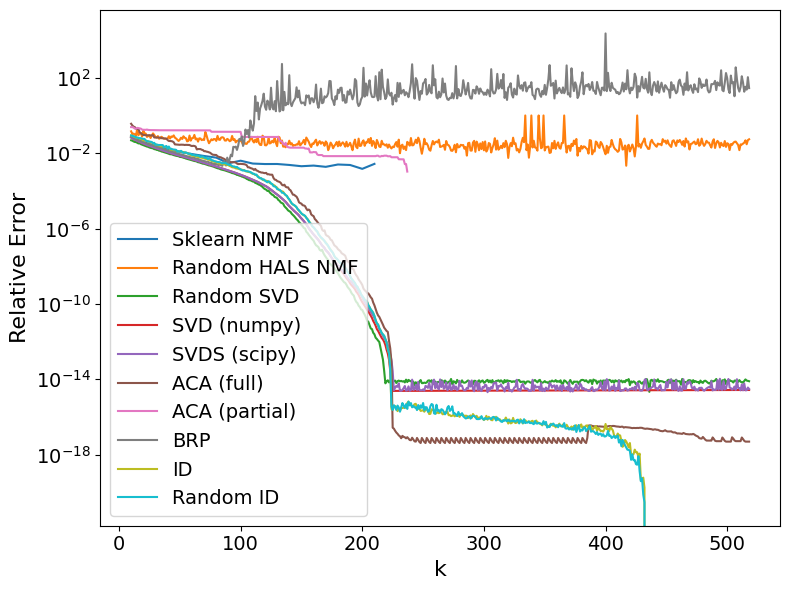

In [153]:
plt.figure(figsize=(8,6))

plt.plot(k_range[::10][:len(sklearn_nmf_errs)], sklearn_nmf_errs, label="Sklearn NMF")
plt.plot(k_range, rHALS_errs, label="Random HALS NMF")
plt.plot(k_range, rSVD_errs, label="Random SVD")
plt.plot(k_range, SVD_errs, label="SVD (numpy)")
plt.plot(k_range, SVDS_errs, label="SVDS (scipy)")
plt.plot(k_range, ACA_full_errs, label="ACA (full)")
plt.plot(k_range[:len(ACA_partial_errs)], ACA_partial_errs, label="ACA (partial)")
plt.plot(k_range, BRP_errs, label="BRP")
plt.plot(k_range, ID_errs, label="ID")
plt.plot(k_range, rID_errs, label="Random ID")

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("k", fontsize=16)
plt.ylabel("Relative Error", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/relative_error_comparison.png")
plt.show()

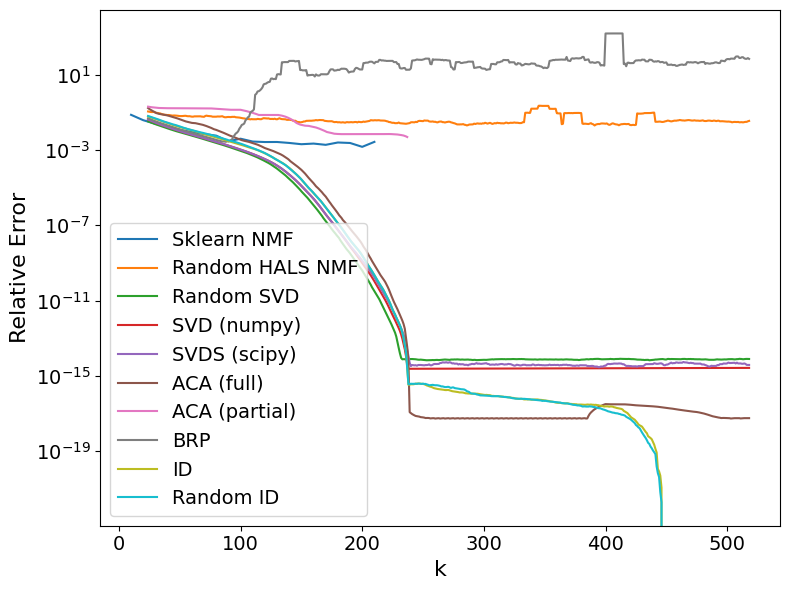

In [154]:
n_mean = 15

plt.figure(figsize=(8,6))

plt.plot(k_range[::10][:len(sklearn_nmf_errs)], sklearn_nmf_errs, label="Sklearn NMF")
plt.plot(k_range[n_mean-1:], np.convolve(rHALS_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random HALS NMF")
plt.plot(k_range[n_mean-1:], np.convolve(rSVD_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random SVD")
plt.plot(k_range[n_mean-1:], np.convolve(SVD_errs, np.ones(n_mean)/n_mean, mode='valid'), label="SVD (numpy)")
plt.plot(k_range[n_mean-1:], np.convolve(SVDS_errs, np.ones(n_mean)/n_mean, mode='valid'), label="SVDS (scipy)")
plt.plot(k_range[n_mean-1:], np.convolve(ACA_full_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (full)")
plt.plot(k_range[n_mean-1:len(ACA_partial_errs)], np.convolve(ACA_partial_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (partial)")
plt.plot(k_range[n_mean-1:], np.convolve(BRP_errs, np.ones(n_mean)/n_mean, mode='valid'), label="BRP")
plt.plot(k_range[n_mean-1:], np.convolve(ID_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ID")
plt.plot(k_range[n_mean-1:], np.convolve(rID_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random ID")

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("k", fontsize=16)
plt.ylabel("Relative Error", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/relative_error_moving_avg_comparison.png")
plt.show()

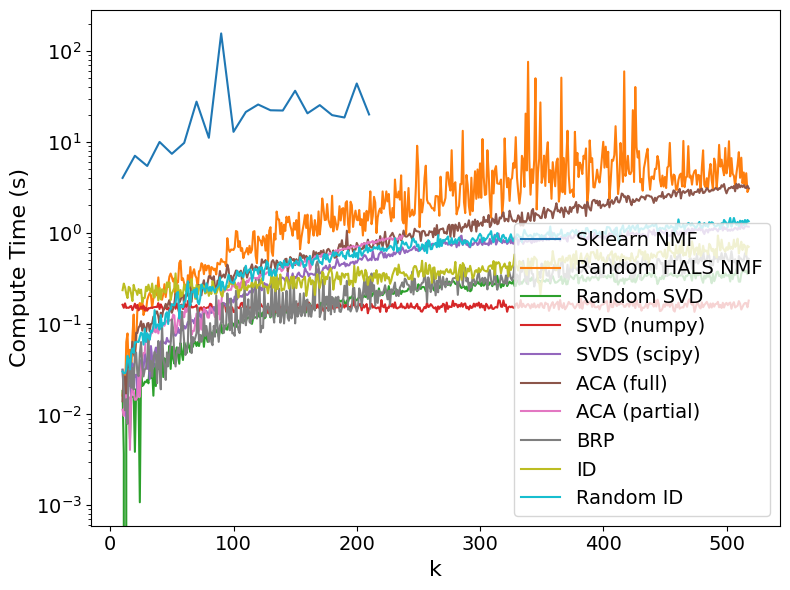

In [155]:
plt.figure(figsize=(8,6))

plt.plot(k_range[::10][:len(sklearn_nmf_errs)], sklearn_nmf_compute_times, label="Sklearn NMF")
plt.plot(k_range, rHALS_compute_times, label="Random HALS NMF")
plt.plot(k_range, rSVD_compute_times, label="Random SVD")
plt.plot(k_range, SVD_compute_times, label="SVD (numpy)")
plt.plot(k_range, SVDS_compute_times, label="SVDS (scipy)")
plt.plot(k_range, ACA_full_compute_times, label="ACA (full)")
plt.plot(k_range[:len(ACA_partial_errs)], ACA_partial_compute_times, label="ACA (partial)")
plt.plot(k_range, BRP_compute_times, label="BRP")
plt.plot(k_range, ID_compute_times, label="ID")
plt.plot(k_range, rID_compute_times, label="Random ID")

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("k", fontsize=16)
plt.ylabel("Compute Time (s)", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/time_comparison.png")
plt.show()

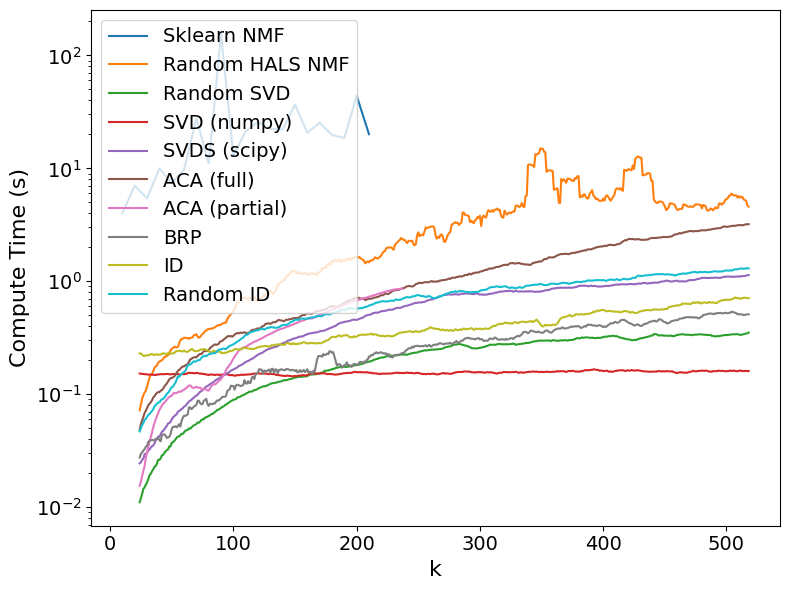

In [157]:
n_mean = 15

plt.figure(figsize=(8,6))

plt.plot(k_range[::10][:len(sklearn_nmf_errs)], sklearn_nmf_compute_times, label="Sklearn NMF")
plt.plot(k_range[n_mean-1:], np.convolve(rHALS_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="Random HALS NMF")
plt.plot(k_range[n_mean-1:], np.convolve(rSVD_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="Random SVD")
plt.plot(k_range[n_mean-1:], np.convolve(SVD_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="SVD (numpy)")
plt.plot(k_range[n_mean-1:], np.convolve(SVDS_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="SVDS (scipy)")
plt.plot(k_range[n_mean-1:], np.convolve(ACA_full_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (full)")
plt.plot(k_range[n_mean-1:len(ACA_partial_errs)], np.convolve(ACA_partial_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (partial)")
plt.plot(k_range[n_mean-1:], np.convolve(BRP_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="BRP")
plt.plot(k_range[n_mean-1:], np.convolve(ID_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="ID")
plt.plot(k_range[n_mean-1:], np.convolve(rID_compute_times, np.ones(n_mean)/n_mean, mode='valid'), label="Random ID")

plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("k", fontsize=16)
plt.ylabel("Compute Time (s)", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/time_moving_avg_comparison.png")
plt.show()

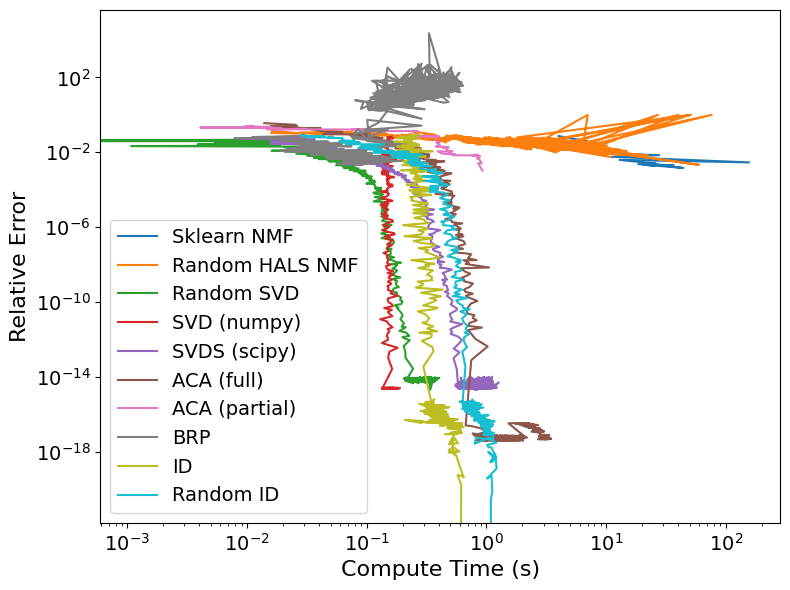

In [158]:
plt.figure(figsize=(8,6))

plt.plot(sklearn_nmf_compute_times, sklearn_nmf_errs, label="Sklearn NMF")
plt.plot(rHALS_compute_times, rHALS_errs, label="Random HALS NMF")
plt.plot(rSVD_compute_times, rSVD_errs, label="Random SVD")
plt.plot(SVD_compute_times, SVD_errs, label="SVD (numpy)")
plt.plot(SVDS_compute_times, SVDS_errs, label="SVDS (scipy)")
plt.plot(ACA_full_compute_times, ACA_full_errs, label="ACA (full)")
plt.plot(ACA_partial_compute_times, ACA_partial_errs, label="ACA (partial)")
plt.plot(BRP_compute_times, BRP_errs, label="BRP")
plt.plot(ID_compute_times, ID_errs, label="ID")
plt.plot(rID_compute_times, rID_errs, label="Random ID")

plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Compute Time (s)", fontsize=16)
plt.ylabel("Relative Error", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/relative_error_time_comparison.png")
plt.show()

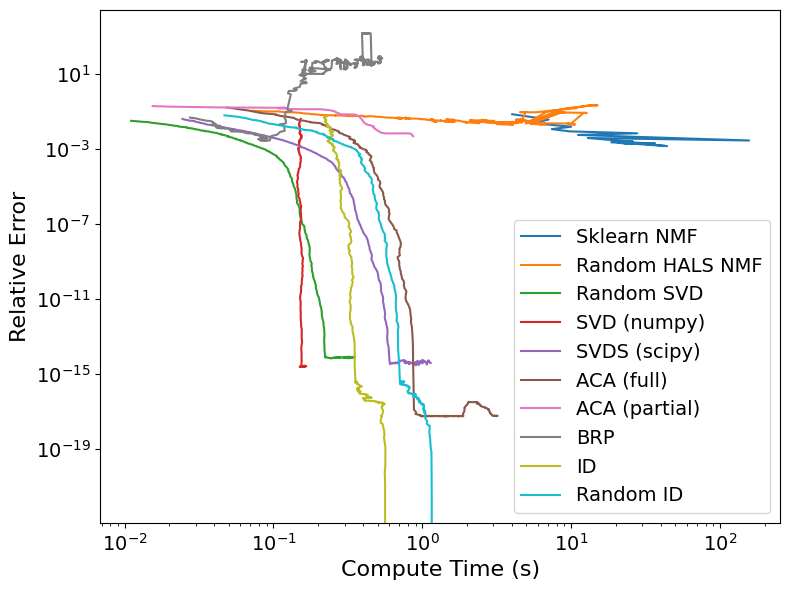

In [161]:
n_mean = 15

plt.figure(figsize=(8,6))

plt.plot(sklearn_nmf_compute_times, sklearn_nmf_errs, label="Sklearn NMF")

plt.plot(np.convolve(rHALS_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(rHALS_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random HALS NMF")

plt.plot(np.convolve(rSVD_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(rSVD_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random SVD")

plt.plot(np.convolve(SVD_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(SVD_errs, np.ones(n_mean)/n_mean, mode='valid'), label="SVD (numpy)")

plt.plot(np.convolve(SVDS_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(SVDS_errs, np.ones(n_mean)/n_mean, mode='valid'), label="SVDS (scipy)")

plt.plot(np.convolve(ACA_full_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(ACA_full_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (full)")

plt.plot(np.convolve(ACA_partial_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(ACA_partial_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ACA (partial)")

plt.plot(np.convolve(BRP_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(BRP_errs, np.ones(n_mean)/n_mean, mode='valid'), label="BRP")

plt.plot(np.convolve(ID_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(ID_errs, np.ones(n_mean)/n_mean, mode='valid'), label="ID")

plt.plot(np.convolve(rID_compute_times, np.ones(n_mean)/n_mean, mode='valid'),
         np.convolve(rID_errs, np.ones(n_mean)/n_mean, mode='valid'), label="Random ID")

plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Compute Time (s)", fontsize=16)
plt.ylabel("Relative Error", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(rootpath+"/relative_error_time_moving_avg_comparison.png")
plt.show()